In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

url = 'http://minio-api.kubby.ninja/fix-dive-storage/projects/1234567890/features/preprocess/preprocess.gzip.parquet'

df = pd.read_parquet(url)

df

,frame_index,blur,total_objects,median_motion,std_motion,features,red,orange,yellow,green,blue,purple,white,black,brown
0,0.0,166.639314,128,NaN,NaN,None,0.004964,0.032175,0.013519,0.003435,0.077371,0.000050,0.037876,0.039811,0.343644
1,1.0,137.255737,129,-3.811660e-12,5.773012,None,0.005425,0.031148,0.013262,0.003967,0.078179,0.000034,0.037785,0.040975,0.346251
2,2.0,129.215376,143,4.419556e-03,5.275668,None,0.005206,0.030064,0.012403,0.004012,0.076630,0.000049,0.043622,0.041968,0.341993
3,3.0,120.201082,167,-5.203282e-14,4.969699,None,0.005676,0.029279,0.012569,0.004323,0.078527,0.000081,0.044171,0.043968,0.342615
4,4.0,115.396284,150,-9.819682e-13,4.699063,None,0.005380,0.026098,0.013278,0.004598,0.080849,0.000065,0.045038,0.046263,0.341912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,4048.0,27.454589,86,-3.692795e-04,4.255781,None,0.049126,0.266886,0.011898,0.025254,0.203703,0.000325,0.014895,0.004985,0.473459
4049,4049.0,26.836729,71,1.362175e-04,3.779635,None,0.053435,0.258299,0.020805,0.018349,0.231993,0.000044,0.018138,0.004850,0.425330
4050,4050.0,27.206008,56,1.343809e-03,3.423098,None,0.048822,0.268829,0.030527,0.017871,0.229372,0.000014,0.018835,0.009926,0.440023
4051,4051.0,27.293872,82,1.087740e-03,4.086150,b'\x00\x00\x00\x00\xcc\r\x84>e\x8e\x96?\x00\x0...,0.049648,0.288490,0.036383,0.024814,0.192460,0.000010,0.020039,0.009279,0.452798


In [2]:
# filter out nulls
df = df[df['features'].notnull()]

df['features'] = df['features'].apply(lambda x: np.frombuffer(x, dtype=np.float32))

/tmp/ipykernel_52471/3771824856.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features'] = df['features'].apply(lambda x: np.frombuffer(x, dtype=np.float32))


In [7]:
def kmeans_inertia(scaled_data, k, alpha_k=0.02):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def best_kmeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kmeans_inertia(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

/home/jack/.local/share/virtualenvs/biocam_quality-MTlfE-4o/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jack/.local/share/virtualenvs/biocam_quality-MTlfE-4o/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jack/.local/share/virtualenvs/biocam_quality-MTlfE-4o/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/jack/.local/share/virtualenvs/biocam_quality-MTlfE-4o/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `

best k: 6


/tmp/ipykernel_52471/330222981.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = model.labels_


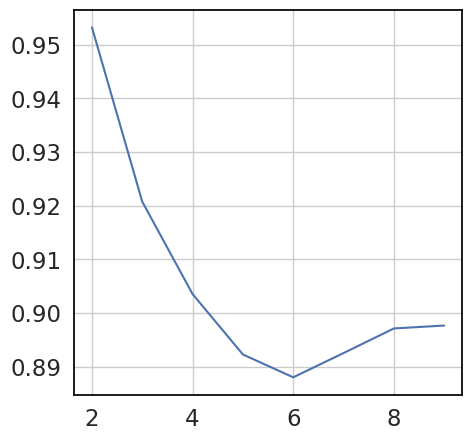

In [13]:
x = np.concatenate(df['features'].values, axis=0).reshape(-1, 2048)

scaler = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=150))
])

xt = scaler.fit_transform(x)

best_k, results = best_kmeans(xt, range(2, 10))

model = KMeans(n_clusters=best_k)

model.fit(xt)

df['cluster'] = model.labels_

print('best k:', best_k)

plt.plot(results)

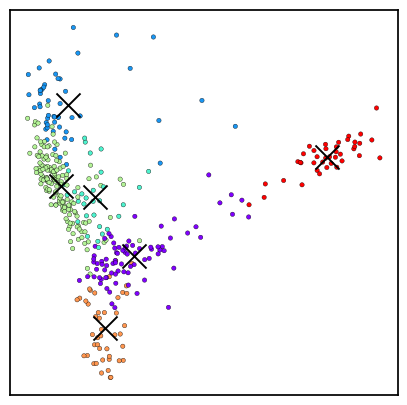

In [14]:
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('rainbow')
sns.set_context('talk')
sns.set(rc={'figure.figsize':(5, 5)})
sns.set(font_scale=1.5)
sns.set_style({'axes.edgecolor': 'black', 'axes.linewidth': 1.0})
sns.set_style({'grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.5})
sns.set_style({'axes.grid': True, 'axes.facecolor': 'white'})

sns.scatterplot(
    x=xt[:, 0],
    y=xt[:, 1],
    hue=model.labels_,
    s=10,
    edgecolor='black',
    palette='rainbow'
)
sns.scatterplot(
    x=model.cluster_centers_[:, 0],
    y=model.cluster_centers_[:, 1],
    color='black',
    s=300,
    marker='x'
)
# remove xticks and yticks
plt.xticks([])
plt.yticks([])

# remove legend
plt.legend([],[], frameon=False)

plt.show()

([<matplotlib.axis.YTick at 0x7f72686b37c0>,
 [Text(0, 0, 'cluster'),
  Text(0, 1, 'red'),
  Text(0, 2, 'blue'),
  Text(0, 3, 'green'),
  Text(0, 4, 'white'),
  Text(0, 5, 'black'),
  Text(0, 6, 'total_objects'),
  Text(0, 7, 'median_motion'),
  Text(0, 8, 'std_motion'),
  Text(0, 9, 'blur')])

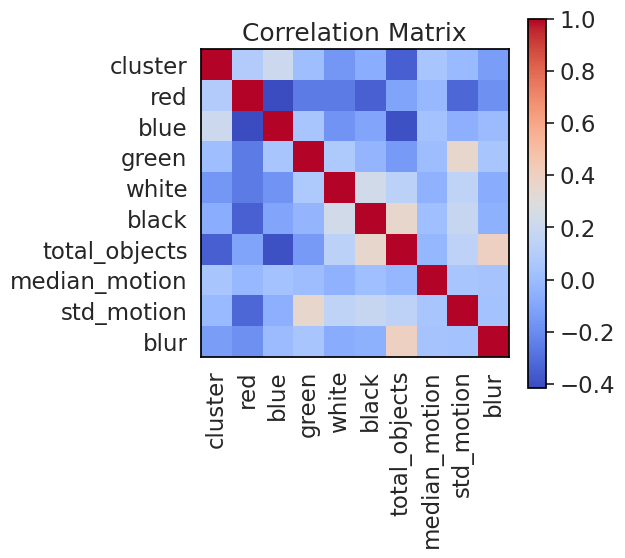

In [21]:
# confusion matrix
fdf = df[['cluster', 'red', 'blue', 'green', 'white', 'black', 'total_objects', 'median_motion', 'std_motion', 'blur']]

# plot correlation matrix
corr = fdf.corr()

plt.figure(figsize=(5, 5))
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()

# remove grid
plt.grid(False)

# show labels
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns, rotation=0)